In [79]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt

import os
import pickle
import gpflow

import tensorflow as tf

2025-03-26 16:18:05.156611: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-26 16:18:06.607581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743027486.946640    7914 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743027487.206009    7914 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-26 16:18:07.890668: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [37]:
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params_lhc = pd.read_csv(key).drop(columns='member')

pft_params   = ['kmax','psi50','jmaxb0','slatop','lmr_intercept_atkin',
                'medlynslope','medlynintercept','froot_leaf','leafcn','leaf_long',
                'KCN','dleaf','r_mort','fsr_pft','xl']
pftix=np.array([p in pft_params for p in params_lhc.columns])
u_params = params_lhc.columns[~pftix]

In [41]:
csv='~/ctsm6_ppe/gen_ensembles/gen_paramfiles/ctsm6lhc_paramranges_11262024.csv'
df = pd.read_csv(csv)
df_main = df[df['include'] == 1]
params=df_main['param'].values

In [53]:
filename = './params/selected_sets.csv'
selected_paramsets = pd.read_csv(filename)
selected_paramsets = selected_paramsets.iloc[:20]

In [55]:
# create dictionary of paramsets
pft_ids = [1,2,3,4,5,6,7,8,10,11,12,13,14]
pset_dict = {}

for param in params:
    if param in pft_params:
        psets = np.ones((len(selected_paramsets),79))*0.5
        cols = [f"{param}_{i}" for i in pft_ids]
        psets[:,pft_ids] = selected_paramsets[cols].values
        pset_dict[param] = psets
    else:
        pset_dict[param] = selected_paramsets[param].values

In [56]:
pset_dict

{'kmax': array([[0.5       , 0.70343256, 0.70343256, ..., 0.5       , 0.5       ,
         0.5       ],
        [0.5       , 0.52516639, 0.52516639, ..., 0.5       , 0.5       ,
         0.5       ],
        [0.5       , 0.15304798, 0.03515913, ..., 0.5       , 0.5       ,
         0.5       ],
        ...,
        [0.5       , 0.30311569, 0.19757482, ..., 0.5       , 0.5       ,
         0.5       ],
        [0.5       , 0.56807445, 0.1145559 , ..., 0.5       , 0.5       ,
         0.5       ],
        [0.5       , 0.96342038, 0.70525651, ..., 0.5       , 0.5       ,
         0.5       ]]),
 'psi50': array([[0.5       , 0.14173786, 0.14173786, ..., 0.5       , 0.5       ,
         0.5       ],
        [0.5       , 0.4296817 , 0.4296817 , ..., 0.5       , 0.5       ,
         0.5       ],
        [0.5       , 0.56195519, 0.43165223, ..., 0.5       , 0.5       ,
         0.5       ],
        ...,
        [0.5       , 0.72698709, 0.15330288, ..., 0.5       , 0.5       ,
         0.5     

In [57]:
# fix some individual PFTs/params
extra_pfts = [0,9,16]
for i in range(20):
    pset_dict['medlynintercept'][i][extra_pfts]= 0.08
# set c3 crops equivalent to c3 grasses
for par in pft_params:
    pset_dict[par][:,15] = pset_dict[par][:,13]

In [58]:
np.save('./params/wave2_testsets_032625_sudokulaimax.npy', pset_dict)

### Sanity check

In [74]:
import pickle
with open("./biome_pft_dict.pkl", "rb") as f:
    biome_pfts = pickle.load(f)

file='../../biomes/sudoku_biomes.nc'
biomes=xr.open_dataset(file)
biome_names = biomes.biome_names.values

In [76]:
obs = xr.open_dataset('wave2_obsStatistics_sudokuBiomes.nc')

In [77]:
emulator_dir = 'emulators_biomelai/'

In [59]:
infile = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/postp/ctsm6lhc_pxbmean_sudoku_1985-2023.nc'
ds_lhc = xr.open_dataset(infile)
lhc_pxb = ds_lhc.where(ds_lhc['crashed'] != 1, drop=True)
lai_lhc = lhc_pxb.TLAI_biome_amax.sel(year=slice('2001','2020')).mean(dim='year').compute()

In [80]:
# load .npy and reconstruct full sample
num_paramsets = 20 # set the number of ensemble members 
psets_dict = np.load('./params/wave2_testsets_032625_sudokulaimax.npy',allow_pickle='TRUE').item()

# Start building a dictionary of all columns
data_dict = {}

# Add scalar/unit-level parameters
data_dict['FUN_fracfixers'] = psets_dict['FUN_fracfixers']
for u in u_params:
    data_dict[u] = psets_dict[u]
    
# Add PFT-level parameters
for p in pft_params:
    data = psets_dict[p]             # shape: (n_samples, n_pfts)
    for j in pft_ids:
        col_name = f"{p}_{j}"
        data_dict[col_name] = data[:, j]  # one column per PFT ID

# Construct the DataFrame once
df = pd.DataFrame(data_dict)
    

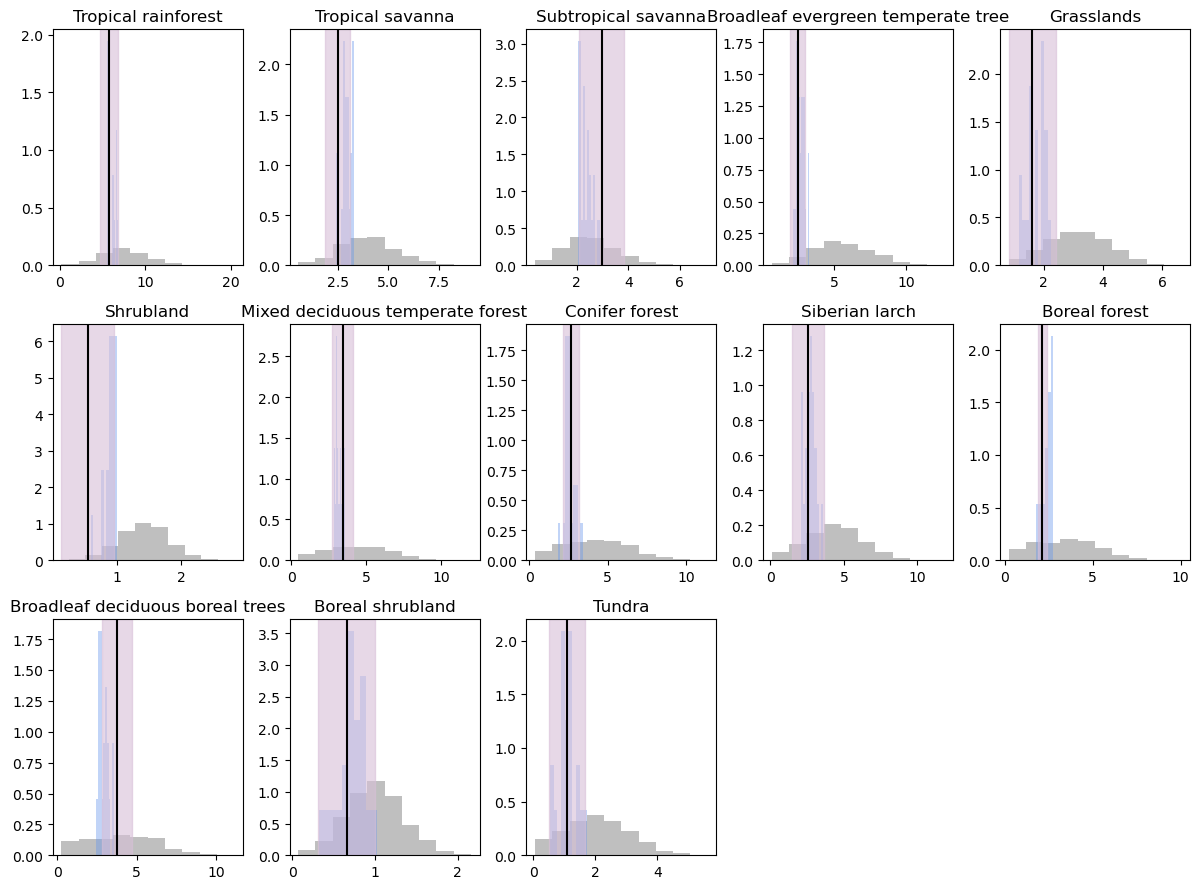

In [83]:
plt.figure(figsize=(12,9))
for b, biome in enumerate(biome_names[1:],start=1):
    plt.subplot(3,5,b)

    obs_mean = obs.LAI_mean.sel(biome=b).values
    obs_var = obs.LAI_stdev.sel(biome=b).values**2

    pfts = biome_pfts[biome]
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols,param_names])
    
    samp = df[cols]
    
    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.predict(samp)

    plt.hist(lai_lhc.isel(biome=b),color='grey',alpha=0.5,density=True)
    plt.axvspan(obs_mean-2*obs_var**0.5,obs_mean+2*obs_var**0.5,color='thistle',alpha=0.6)
    plt.hist(y_pred.numpy().flatten(),alpha = 0.4,color='cornflowerblue',density=True)
    plt.axvline(obs_mean,c='k')
    
    plt.title(biome)

plt.tight_layout()